In [168]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.ticker as mticker
import time
import csv
import zoneinfo
import matplotlib.pyplot as plt
import matplotlib.colors

In [187]:
data_fn = '../data/taobao/hourly_categoryid_timeseries_cst.csv'
df = pd.read_csv(data_fn)
display(df)

,category_id,1511539200.0,1511542800.0,1511546400.0,1511550000.0,1511553600.0,1511557200.0,1511560800.0,1511564400.0,1511568000.0,...,1512284400.0,1512288000.0,1512291600.0,1512295200.0,1512298800.0,1512302400.0,1512306000.0,1512309600.0,1512313200.0,1512316800.0
0,80,22297,10776,5488,3514,3414,4235,9680,17688,23702,...,48034,48457,43202,44537,53101,63364,75239,73551,54448,NaN
1,1147,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,2171,236,159,56,33,53,47,131,309,176,...,470,361,539,515,546,666,939,768,527,NaN
3,2410,134896,61864,33275,22724,19812,25889,56209,107351,139921,...,283107,283522,255907,255737,315729,379126,439208,432943,317583,NaN
4,2424,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9434,5159111,24953,11663,5971,4357,3195,4628,10349,19550,25485,...,53431,52891,47439,47323,59496,72065,82148,81254,59227,NaN
9435,5159987,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9436,5160054,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9437,5161669,27754,13068,6856,4464,4166,5336,11893,22091,29433,...,59424,59306,53077,54157,65194,78162,92254,91253,66374,NaN


In [188]:
timeseries = df.to_numpy()
# remove columns
timeseries = timeseries[:,1:-1]
# remove zero rows
timeseries = timeseries[~np.all(timeseries == 0, axis=1)]
print(timeseries.shape)

(4734, 216)


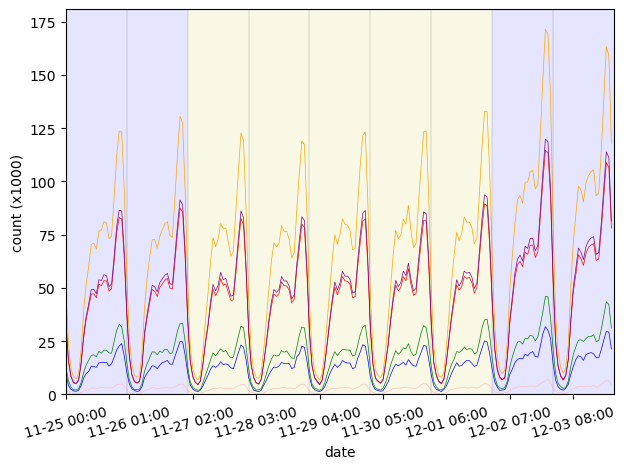

In [213]:
d = times = [datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="Asia/Shanghai")).strftime('%m-%d %H:%M') for timestamp in df.columns[1:-1]]
weekdays_timestamps = np.array([datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="Asia/Shanghai")).weekday() for timestamp in df.columns[1:-1]])


scale = 1000

# make figure + axes
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlabel('date')
ax.set_ylabel(f'count (x{scale})')

rand_ind = np.random.randint(0, timeseries.shape[0], 6)
# draw one line
ln1, = ax.plot(timeseries[rand_ind[0]]/scale, c='blue', lw=0.5)
ln2, = ax.plot(timeseries[rand_ind[1]]/scale, c='red', lw=0.5)
ln3, = ax.plot(timeseries[rand_ind[2]]/scale, c='green', lw=0.5)
ln4, = ax.plot(timeseries[rand_ind[3]]/scale, c='purple', lw=0.5)
ln5, = ax.plot(timeseries[rand_ind[4]]/scale, c='orange', lw=0.5)
ln6, = ax.plot(timeseries[rand_ind[5]]/scale, c='pink', lw=0.5)
# ln7, = ax.plot(outliers[0], c='black', lw=1)

Z = np.repeat(weekdays_timestamps.reshape(1,216),int(ax.get_ylim()[1]+1),axis=0).reshape(int(ax.get_ylim()[1]+1),216) 
cvals = [0,1,2,3,4,5,6]
colors = ['y','y','y','y','y','b','b']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
c = ax.pcolor(Z, alpha=0.1, edgecolor=None, snap=True, cmap=cmap) 
ax.vlines(range(0,216,24),0,int(ax.get_ylim()[1]),colors='black', linewidth=0.1)

# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''

# make and use the formatter
mt = mticker.FuncFormatter(listifed_formatter)
ax.xaxis.set_major_formatter(mt)

# set the default ticker to only put ticks on the integers
loc = ax.xaxis.get_major_locator()
loc.set_params(integer=True)

# rotate the labels
[lab.set_rotation(15) for lab in ax.get_xticklabels()]
plt.show()

## Anomaly Detection

In [522]:
# General shape outliers
mean_timeseries = np.mean(timeseries, axis=0).reshape((9,24))
outlier_radius = 5
daily_outliers = 5
min_relative_mean = 0.01

mean_weekdays = np.mean(mean_timeseries[2:-2], axis=0)
sort_mean_weekdays = np.argsort(mean_weekdays)
sort_mean_weekdays_low = sort_mean_weekdays - outlier_radius
sort_mean_weekdays_high = sort_mean_weekdays + outlier_radius

mean_weekends = np.mean(np.concatenate((mean_timeseries[:2,:],mean_timeseries[-2:,:])), axis=0)
sort_mean_weekends = np.argsort(mean_weekends)
sort_mean_weekends_low = sort_mean_weekends - outlier_radius
sort_mean_weekends_high = sort_mean_weekends + outlier_radius
outliers_ind = []
outliers = []

for ind, row in enumerate(timeseries):
    # reshape to daily
    daily = row.reshape((9,24))
    sort_ind = np.argsort(daily, axis=1)
    weekends = np.concatenate((sort_ind[:2,:],sort_ind[-2:,:]))
    weekdays = sort_ind[2:-2,:]
    in_between_weekdays = np.logical_or(weekdays < sort_mean_weekdays_low, weekdays > sort_mean_weekdays_high)
    in_between_weekends = np.logical_or(weekends < sort_mean_weekends_low, weekends > sort_mean_weekends_high)
    # print(np.sum(in_between_weekdays), np.sum(in_between_weekends))
    if np.mean(daily) > min_relative_mean*np.mean(mean_timeseries) and (np.sum(in_between_weekdays) > daily_outliers*5 or np.sum(in_between_weekends) > daily_outliers*4): # outlier
        outliers_ind.append(ind)
        outliers.append(row)

outliers = np.array(outliers)
print('num outliers:', outliers.shape[0])

num outliers: 32


In [563]:
# Weird Minimums
outliers=[]
mean_timeseries = np.mean(timeseries, axis=0).reshape((9,24))
min_left = 6
min_right = 22

for ind, row in enumerate(timeseries):
    # reshape to daily
    daily = row.reshape((9,24))
    argmin_daily = np.argmin(daily, axis=1)
    if np.any(argmin_daily > min_left) and np.any(argmin_daily < min_right):
        outliers_ind.append(ind)
        outliers.append(row)

outliers = np.array(outliers)
print('num outliers:', outliers.shape[0])

num outliers: 10


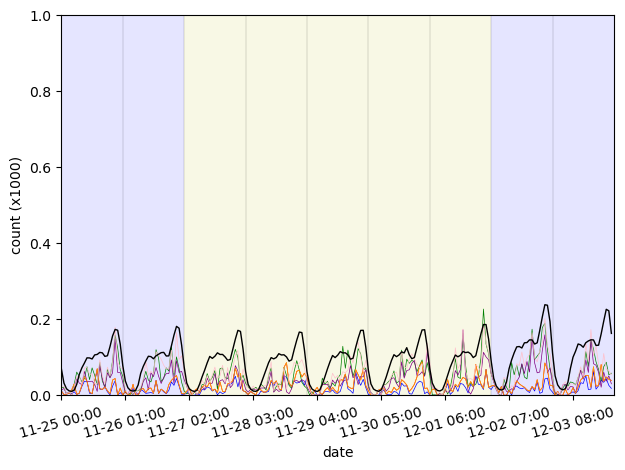

In [573]:
d = times = [datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="Asia/Shanghai")).strftime('%m-%d %H:%M') for timestamp in df.columns[1:-1]]
weekdays_timestamps = np.array([datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="Asia/Shanghai")).weekday() for timestamp in df.columns[1:-1]])


scale = 1000

# make figure + axes
fig, ax = plt.subplots(tight_layout=True)
ax.set_xlabel('date')
ax.set_ylabel(f'count (x{scale})')

rand_ind = np.random.randint(0, outliers.shape[0], 6)
# draw one line
ln1, = ax.plot(outliers[rand_ind[0]]/scale, c='blue', lw=0.5)
ln2, = ax.plot(outliers[rand_ind[1]]/scale, c='red', lw=0.5)
ln3, = ax.plot(outliers[rand_ind[2]]/scale, c='green', lw=0.5)
ln4, = ax.plot(outliers[rand_ind[3]]/scale, c='purple', lw=0.5)
ln5, = ax.plot(outliers[rand_ind[4]]/scale, c='orange', lw=0.5)
ln6, = ax.plot(outliers[rand_ind[5]]/scale, c='pink', lw=0.5)
ln7, = ax.plot(mean_timeseries.flatten()/np.max(mean_timeseries)*ax.get_ylim()[1], c='black', lw=1)

Z = np.repeat(weekdays_timestamps.reshape(1,216),int(ax.get_ylim()[1]+1),axis=0).reshape(int(ax.get_ylim()[1]+1),216) 
cvals = [0,1,2,3,4,5,6]
colors = ['y','y','y','y','y','b','b']
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
c = ax.pcolor(Z, alpha=0.1, edgecolor=None, snap=True, cmap=cmap) 
ax.vlines(range(0,216,24),0,int(ax.get_ylim()[1]),colors='black', linewidth=0.1)

# helper function for the formatter
def listifed_formatter(x, pos=None):
    try:
        return d[int(x)]
    except IndexError:
        return ''

# make and use the formatter
mt = mticker.FuncFormatter(listifed_formatter)
ax.xaxis.set_major_formatter(mt)

# set the default ticker to only put ticks on the integers
loc = ax.xaxis.get_major_locator()
loc.set_params(integer=True)

# rotate the labels
[lab.set_rotation(15) for lab in ax.get_xticklabels()]
plt.show()